# Extracting altitude & temperature data from Tom Scott's falling garlic bread

All this is only tested in Python 3.6, required packages:
```
youtube-dl
Numpy
Maptlotlib
Pillow
IPython
Pandas
```
Not all are absolutely required, but I used all of them

In [1]:
from PIL import Image
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import json
import re
import random
from IPython.display import display
import pandas as pd

## 1. Preparing video / extracting frames with information
The video was downloaded from Youtube

```youtube-dl -f 'bestvideo' -o garlic_bread_video.mp4 https://www.youtube.com/watch?v=YKAblynZYhI``` 

and 1 frame for every second extracted with FFMPEG, cropped to the area where the information is shown.

```ffmpeg -i garlic_bread_video.mp4 -vf "crop=147:116:1645:71, fps=1" frames/%05d.png```

The frames not containing the information have to be deleted manually (first 42 seconds)

## 2. Building digit database
I first tried to to this with some OCR library, but it was slow and unreliable. So I used a nearest neighbor classifier:
Thankfully Tom used a constand width font, so every digit could be selected via pixel coordinates. These had to be aligned pixel-perfect, so the NN classifier works.

In [2]:
# crop boxes for single digits:
boxes = [
    (42,7,42+32,7+45),
    (69,7,69+32,7+45),
    (108,7, 108+32, 7+45),
    (42,67,42+32,67+45),
    (69,67,69+32,67+45),
    (108,67, 108+32, 67+45)
]

To make the data more suitable for the NN classifier (and remove much of the background variation), the images are converted to black and white via a threshold

In [3]:
def flatten(im):
    flat = np.mean(np.asarray(im), axis=2)
    mask = flat > 200
    flat[mask] = 1
    flat[~mask] = 0
    return flat

Because every digit should look exactly the same (except for the background), as a "training" set we only need one sample per digit. So I just searchd through some frames until I had all of them in the right order. 
The dataset includes in this order:
 - digits 0 to 9
 - empty
 - minus sign
So the dataset has a size of 12, with indices 0 to 11

In [ ]:
digits = {}
# filter non-images from dir
frames = [f for f in os.listdir('frames') if re.match('.*\.png', f)]
while True:
    with Image.open(os.path.join('frames', random.choice(frames))) as im:
        box = random.choice(boxes)
        d = im.crop(box)
        display(im.crop(box))
        ctrl = input()
        if ctrl == 'q':
            break
        elif ctrl != '':
            digits[ctrl] = d
            if len(digits) == 12:
                break
        else:
            continue

In [33]:
# sort and save to list
digittuple = list(digits.items())
digittuple.sort()
# save digit set for later use
digitsnp = np.array(np.array([flatten(d[1]) for d in digittuple[2:] + digittuple[:2]]))
np.save('digits', digitsnp)

In [4]:
# load digit dataset from file
digitsnp = np.load('digits.npy')

## 3. Recognizing via Nearest Neighbor

Recognition is just a Nearest Neighbor classifier, with some 

In [5]:
def recognize_digit(im):
    # NN classifier
    substr = np.abs(flatten(im) - digitsnp)
    res = np.argmin(np.sum(substr.reshape(digitsnp.shape[0],-1), axis=1))
    # empty space
    if res == 10:
        return 0
    # minus sign
    if res == 11:
        return -1
    # all other digits
    else:
        return res

Now all the frames can be read in. If the temperature is <-10, the minus sign is recognized by a simple check if the pixels are bright, because no other digit is displayed there (so recognition is not necessary)

In [6]:
frames = os.listdir('frames')
N = len(frames)
# setup target arrays
time = np.arange(26, N+26)
alt = np.empty(N)
temp = np.empty(N)

for i, frame in enumerate(frames):
    print(f'\rProcessing frame {i+1}/{N}, {(i+1)/N * 100:.3f}%', end='')
    with Image.open(os.path.join('frames', frame)) as im:
        # recognize all crop boxes
        recog = [recognize_digit(im.crop(box)) for box in boxes]
        # reconstruct numbers from recognized digits
        alt[i] = recog[0] * 10 + recog[1] + recog[2] * 0.1
        # -10 < T < 0
        if recog[3] == -1:
            minus = -1
            recog[3] = 0
        # T <= -10
        elif np.mean(im.getpixel((33,93))) > 200:
            minus = -1
        else:
            minus = 1
        temp[i] = minus * (recog[3] * 10 + recog[4] + recog[5] * 0.1)

# save data to csv
df = pd.DataFrame(np.column_stack([alt, temp]), index=time, columns=["Altitude[km]", "Temperature[Celsius]"])
df.index.name = 'Time[s]'
df.to_csv('all_data.csv', float_format='%.1f')

Processing frame 9477/9477, 100.000%

## 4. Plotting some data

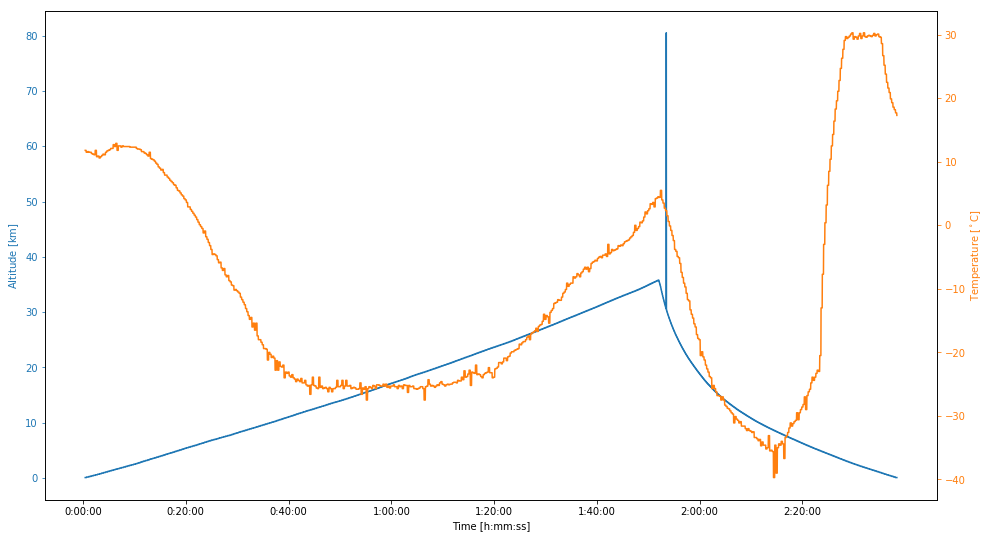

In [7]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.plot(time, alt, color='C0')
ax1.set_xlabel('Time [h:mm:ss]')
ax1.tick_params(axis='y', colors='C0')
ax1.set_ylabel('Altitude $\mathrm{[km]}$', color='C0')
ax2.plot(time, temp, color='C1')
ax2.tick_params(axis='y', colors='C1')
ax2.set_ylabel('Temperature $\mathrm{[^\circ C]}$', color='C1')
ticks = np.arange(0, max(time), 1200)
ax1.xaxis.set_ticks(ticks)
ax1.xaxis.set_ticklabels([f'{t//3600}:{(t%3600)//60:02d}:{(t%60):02d}' for t in ticks]);